In [1]:
import sympy.physics.mechanics as mech
import sympy
import control
import matplotlib.pyplot as plt
import scipy.integrate
import sympy.physics.control
import numpy as np

In [17]:
# symbols
t = sympy.symbols('t') # time
l, g, m_c, m_b, c_r, c_t = sympy.symbols('l, g, m_c, m_b, c_r, c_t') # model parameters
u = mech.dynamicsymbols('u') # motor torque
x, theta = mech.dynamicsymbols('x, theta') # pos and angle DOF of inv pend
v, omega = mech.dynamicsymbols('v, omega') # deriv of [x, theta]

# frames
mech.init_vprinting()
frame_i = mech.ReferenceFrame('i')
frame_p = frame_i.orientnew('p', 'Axis', (theta, frame_i.y))
rot_kd = (frame_p.ang_vel_in(frame_i) - omega*frame_i.y).dot(frame_i.y)
frame_p.set_ang_vel(frame_i, omega*frame_i.y)

# points
point_o = mech.Point('o')
point_o.set_vel(frame_i, 0)
point_c = point_o.locatenew('c', x*frame_i.x) # cart center of mass
point_c.set_vel(frame_p, 0)
trans_kd = (point_c.vel(frame_i) - v*frame_i.x).dot(frame_i.x)
point_c.set_vel(frame_i, v*frame_i.x)

point_b = point_c.locatenew('b', l*frame_p.z)  # ball center of mass
point_b.set_vel(frame_p, 0)
point_b.v1pt_theory(point_c, frame_i, frame_p)

#point_c.set_vel(frame_i, v*frame_i.x)

# treating cart and ball as point masses
cart = mech.Particle('cart', point_c, m_c)  # cart can only translate, so this is fine
ball = mech.Particle('ball', point_b, m_b) # this assumes pendulum is small and ball is point-like

# solve for equations of motion using Kanes Method
KM = mech.KanesMethod(
    frame=frame_i,
    q_ind=[x, theta],
    u_ind=[v, omega],
    bodies=[cart, ball],
    forcelist=[
        (point_b, -m_b*g*frame_i.z),  # gravity (point, vector)
        (point_b, -c_t*v*frame_i.x),  # translational damping
        (point_c, u*frame_i.x),  # force on cart
        (frame_p, -c_r*omega*frame_i.y), # rotational damping
    ],
    kd_eqs=[
        rot_kd, # derivative of position is velocity
        trans_kd # derivative of theta is omega
    ]
)
Fr, Fr_star = KM.kanes_equations()

x_vect = sympy.Matrix.vstack(KM.q, KM.u) # state vector
f_vect = KM.rhs()  # right hand side to integrate ODE and get jacobians
f_vect.simplify()

(Fr, Fr_star, x_vect, f_vect)

⎛                                                                             
⎜                                                                             
⎜                                                                             
⎜                                                                             
⎜                                                                             
⎜                                                                             
⎜                                          ⎡       2                          
⎜⎡              -cₜ⋅v + u               ⎤  ⎢l⋅m_b⋅ω ⋅sin(θ) - l⋅m_b⋅cos(θ)⋅ω̇ 
⎜⎢                                      ⎥, ⎢                                  
⎜⎣-cᵣ⋅ω - cₜ⋅l⋅v⋅cos(θ) + g⋅l⋅m_b⋅sin(θ)⎦  ⎢             2                    
⎜                                          ⎣          - l ⋅m_b⋅ω̇ - l⋅m_b⋅cos(
⎜                                                                             
⎜                                                   

In [18]:
cart.linear_momentum(frame_i).diff(t, frame_p)

In [19]:
ball.angular_momentum(point_c, frame_i).diff(t, frame_p)

In [20]:
#A, B, u_vect = KM.linearize(A_and_B=True)
u_vect = sympy.Matrix([u])

In [21]:
cart.linear_momentum(frame_i), cart.angular_momentum(point_c, frame_i)

In [22]:
ball.linear_momentum(frame_i), ball.angular_momentum(point_c, frame_i)

In [24]:
A = f_vect.jacobian(x_vect)
A.simplify()
A

⎡0                                                                            
⎢                                                                             
⎢0                                                                            
⎢                                                                             
⎢                                                                             
⎢                     5⋅cᵣ⋅m_b⋅ω⋅sin(θ)   cᵣ⋅m_b⋅ω⋅sin(3⋅θ)                   
⎢                   - ───────────────── - ───────────────── - cᵣ⋅m_c⋅ω⋅sin(θ) 
⎢                             4                   4                           
⎢0                  ──────────────────────────────────────────────────────────
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

In [26]:
B = f_vect.jacobian(u_vect)
B.simplify()
B

⎡          0          ⎤
⎢                     ⎥
⎢          0          ⎥
⎢                     ⎥
⎢          1          ⎥
⎢  ─────────────────  ⎥
⎢         2           ⎥
⎢  m_b⋅sin (θ) + m_c  ⎥
⎢                     ⎥
⎢       -cos(θ)       ⎥
⎢─────────────────────⎥
⎢  ⎛       2         ⎞⎥
⎣l⋅⎝m_b⋅sin (θ) + m_c⎠⎦

In [27]:
op_point_vertical = {
    theta: 0,
    omega: 0,
    v: 0,
    x: 0
}

In [28]:
y_vect = sympy.Matrix([x, theta])
C = y_vect.jacobian(x_vect)
D = y_vect.jacobian(u_vect)
C, D

⎛⎡1  0  0  0⎤  ⎡0⎤⎞
⎜⎢          ⎥, ⎢ ⎥⎟
⎝⎣0  1  0  0⎦  ⎣0⎦⎠

In [29]:
p_vect = sympy.Matrix([l, g, m_c, m_b, c_r, c_t])
p_vect.T

[l  g  m_c  m_b  cᵣ  cₜ]

In [30]:
param_vals = {l: 1, g: 9.8, m_c: 1, m_b: 1, c_r: 1, c_t: 1}

In [31]:
sys = control.ss(A.subs(op_point_vertical).subs(param_vals),
                    B.subs(op_point_vertical).subs(param_vals),
                    C.subs(op_point_vertical).subs(param_vals),
                    D.subs(op_point_vertical).subs(param_vals))
sys

<LinearIOSystem:sys[2]:['u[0]']->['y[0]', 'y[1]']>

In [13]:
control.ss2tf(sys)

TransferFunction([[array([ 1. ,  1. , -9.8])], [array([-1., -1.,  0.])]], [[array([ 1.00000000e+00,  2.00000000e+00, -1.86000000e+01, -9.80000000e+00,
        1.37702055e-14])], [array([  1. ,   2. , -18.6,  -9.8,   0. ])]])

In [32]:
input_u = control.ss([], [], [], [[1]])
output_x = control.ss([], [], [], [[1, 0]])
output_theta = control.ss([], [], [], [[0, 1]])
control.ss2tf(output_theta*sys*input_u)

TransferFunction(array([-1., -1.]), array([  1. ,   2. , -18.6,  -9.8]))

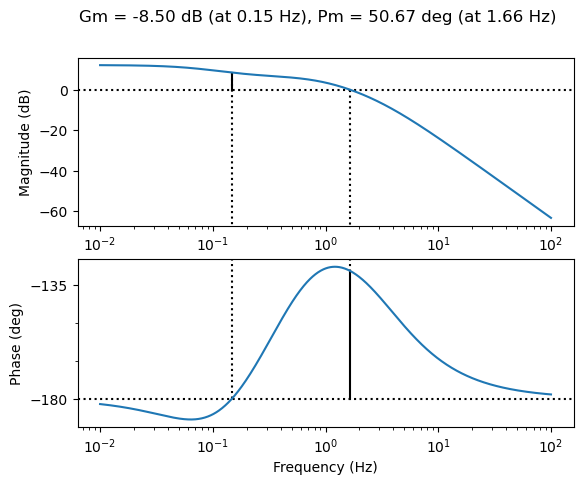

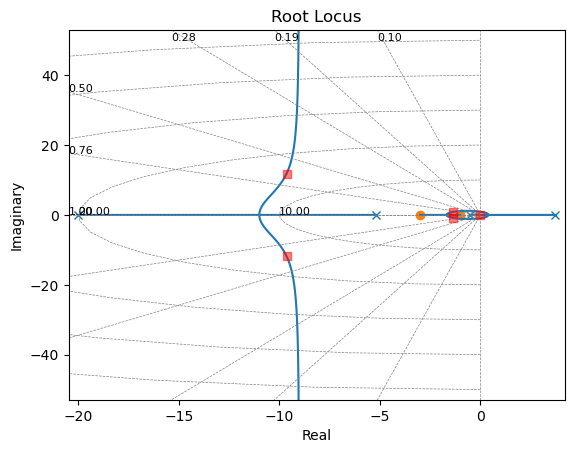

In [39]:
s = control.tf([1, 0], [1])
H_theta = -40*(s/3 + 1)/(s/20 + 1) # 364  (lead compensator)

plt.figure()
control.bode(output_theta*sys*H_theta, margins=True, dB=True, Hz=True);

plt.figure()
control.rlocus(output_theta*sys*H_theta);

Gc_inner = control.feedback(sys*H_theta, output_theta)

plt.plot(np.real(Gc_inner.poles()), np.imag(Gc_inner.poles()), 'rs', alpha=0.5)

In [40]:
control.zeros(Gc_inner[0, 0])

array([ 2.6701735+0.j, -3.6701735+0.j, -3.       +0.j])

In [41]:
### input_theta_r = control.ss([], [], [], [[1]])
output_x = control.ss([], [], [], [[1, 0]])
output_theta = control.ss([], [], [], [[0, 1]])

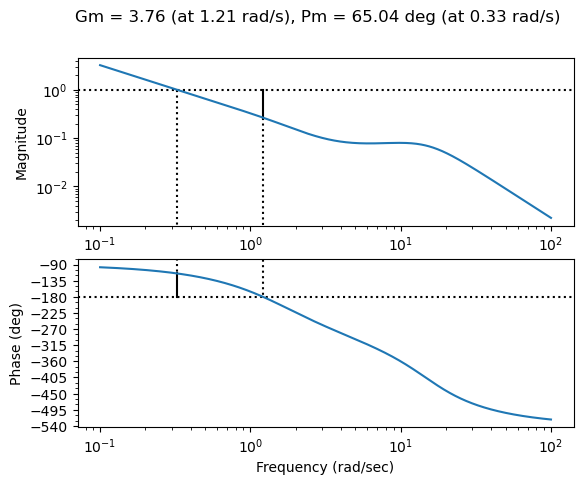

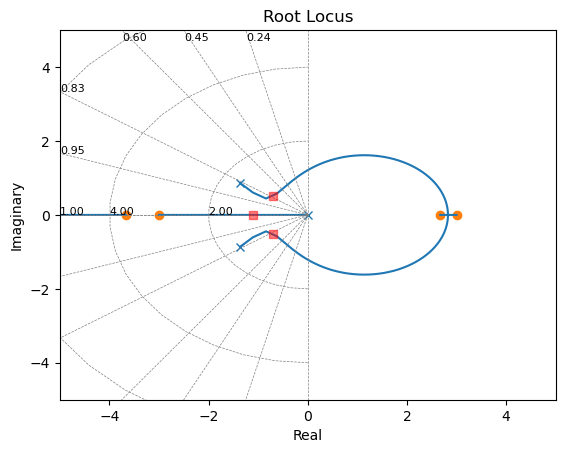

In [45]:
H_x = -0.025*(s/3 - 1)/(s/10 + 1) # lead compensator
G1 = output_x*Gc_inner*H_x

plt.figure()
control.bode(G1, margins=True);

plt.figure()
control.rlocus(output_x*Gc_inner*H_x, xlim=[-5, 5], ylim=[-5, 5]);

Gc_outer = control.feedback(Gc_inner*H_x, output_x)
plt.plot(np.real(Gc_outer.poles()), np.imag(Gc_outer.poles()), 'rs', alpha=0.5)

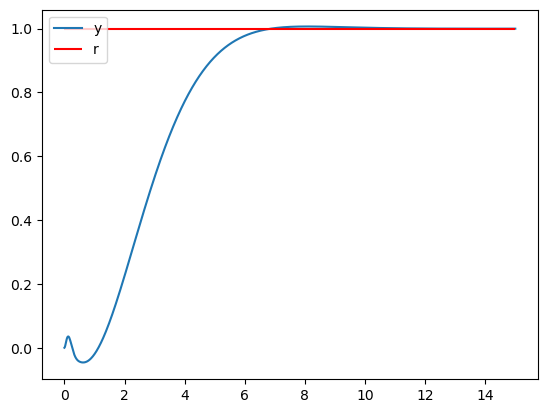

In [46]:
res = control.step_response(Gc_outer[0, 0], T=np.linspace(0, 15, 1000))
plt.plot(res.t, res.y[0, 0, :], label='y')
plt.hlines(1, 0, res.t[-1], color='r', label='r')
plt.legend()

# Create a discrete realization of our controller

Note here, we use a continuous time state space, you can do better if you dt is fixed, and you can use a discrete time state space (see discrete control classes in graduate school)

In [47]:
control.tf2ss(H_x)

class ContinuousTfRealization:
    """
    Simple realization of a continuous transfer function using
    euler integration, this is only a good approx. for dt small
    compared to time constants of system
    """
    def __init__(self, tf):
        self.ss = control.tf2ss(tf)
        self.x = np.zeros(self.ss.A.shape[0])
    
    def update(self, r, y, dt):
        """
        Update controller for one step
        @param y: output
        @param r: reference input
        @param dt: time step
        """
        u = [r - y] # error
        x_dot = self.ss.A@self.x + self.ss.B@u
        self.x = self.x + x_dot*dt # simple euler integration, you can do better with rk45
        y = self.ss.C@self.x + self.ss.D@u
        return y[0]

In [48]:
def simulate_with_controller(tf, dt, delay, p_r, params, H_theta, H_x, f_rhs):
    """
    @params tf: final time
    @params dt: update rate of controller
    @params delay: delay periods for controller
    @params p_r: desired position
    @params params: model parameters
    @params H_theta: theta inner loop control
    @params H_x: position outer loop control
    @params f_rhs: dynamics function x_dot = f(x, u, p)
    """
    u0 = 0
    x0 = np.array([0, 0, 0, 0])
    
    f_dynamics = lambda t, x: f_rhs(x, [u], params)
    controller_theta = ContinuousTfRealization(H_theta)
    controller_x = ContinuousTfRealization(H_x)
    
    t_vect = np.arange(0, tf, dt)
    data = {
        't': [0],
        'x': [x0],
        'u': [u0],
    }

    x = x0
    for i in range(len(t_vect) - 1):
        p = x[0]
        theta = x[1]
        # simulate delay
        if delay > 0 and i > delay:
            p = data['x'][i-delay][0]
            theta = data['x'][i-delay][1]
        
        theta_r = controller_x.update(p_r, p, dt)
        u = controller_theta.update(theta_r, theta, dt)

        # integrate continuous dynamics with fixed control for dt seconds
        # this simulation is pretty slow, because we need to stop the solve
        # every dt seconds to update the controller, if you embed the controllers
        # into the function you send to the solver it is much faster, but a bit 
        # tricky, as you have to add the controller states as well
        res = scipy.integrate.solve_ivp(
            fun=lambda t, x: f_rhs(x, [u], params),
            y0=x, t_span=(t_vect[i], t_vect[i+1]), rtol=1e-1, atol=1e-1)
        x = res.y[:, -1]
        data['t'].append(t_vect[i+1])
        data['x'].append(x)
        data['u'].append(u)

    for k in data.keys():
        data[k] = np.array(data[k])


    plt.figure(figsize=(15, 10))
    plt.subplot(211)
    plt.plot(data['t'], data['x'][:, 0], label='x')
    plt.xlabel('t, sec')
    plt.ylabel('x, m')
    plt.subplot(212)
    plt.plot(data['t'], np.rad2deg(data['x'][:, 1]), label='theta')
    plt.xlabel('t, sec')
    plt.ylabel('theta, deg')

In [49]:
f_rhs = sympy.lambdify([x_vect, u_vect, p_vect], list(f_vect))
params = p_vect.subs(param_vals)

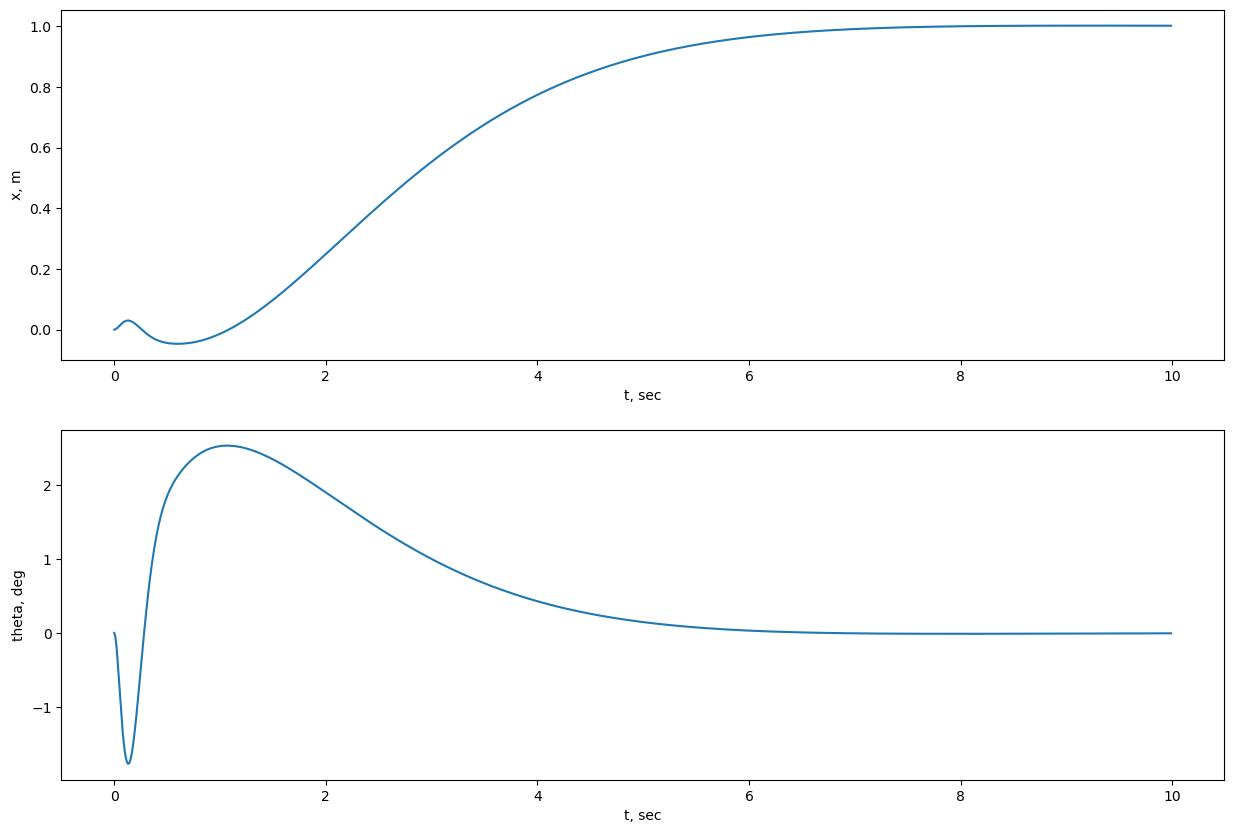

In [50]:
simulate_with_controller(
    tf=10, # final time
    dt=0.01, # will destabilize if controller is not updated quickly enough
    delay=0, # delay controll 10 periods
    p_r=1, # desired x position
    params=p_vect.subs({l: 1, g: 9.8, m_c: 1, m_b: 1, c_r: 1, c_t: 1}),
    H_theta=H_theta, # inner theta loop control
    H_x=H_x, # outer position loop control
    f_rhs=f_rhs)

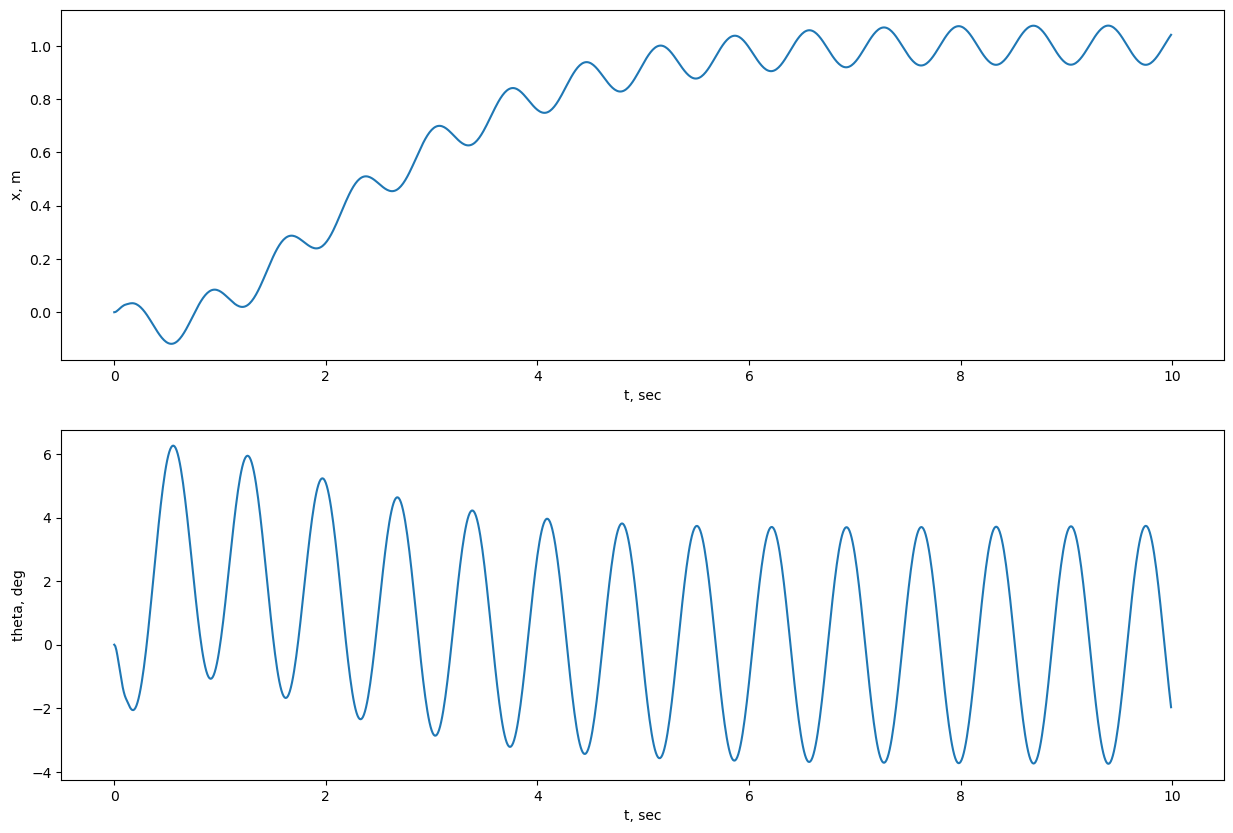

In [51]:
f_rhs = sympy.lambdify([x_vect, u_vect, p_vect], list(f_vect))
params = p_vect.subs(param_vals)
simulate_with_controller(
    tf=10, # final time
    dt=0.01, # will destabilize if controller is not updated quickly enough
    delay=10, # delay control 1 period
    p_r=1, # desired x position
    params=p_vect.subs({l: 1, g: 9.8, m_c: 1, m_b: 1, c_r: 1, c_t: 1}),
    H_theta=H_theta, # inner theta loop control
    H_x=H_x, # outer position loop control
    f_rhs=f_rhs)